# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

#Set percentage of validation batch
valid_batch = 0.2

#Import the data sets
data_dir = '/data/landmark_images/'

train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'


#Do transforms for each data set
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])
                                         ])


testing_transforms = transforms.Compose([transforms.Resize(256), 
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(), 
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])
                                        ])


#load datasets with Imagefolder
image_datasets = [datasets.ImageFolder(train_dir, transform=training_transforms),
                  datasets.ImageFolder(test_dir, transform=testing_transforms)]

#Split train data to get a set for validation

num_train = len(image_datasets[0])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_batch*num_train))
train_idx , valid_idx = indices[split:], indices[:split]

#define samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(image_datasets[0], batch_size = 20, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(image_datasets[0], batch_size = 20, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(image_datasets[1], batch_size = 20)



loaders_scratch = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}
#Identify classes
classes = image_datasets[0].classes


#Measure the number of data points in each data set
print(len(image_datasets[0]))
print(len(image_datasets[0]))
print(len(image_datasets[1]))
print(len(classes))


4996
4996
1250
50


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: My code performs a series of transformations for the training data, to make sure it extracts enough elements for the training set. it rotates 30 degrees, crops it to 224 pixels, does a horizontal flip and normalizes the images. 
I choose the 224 pixels size, because it's a decent size to keep a good resolution and capture the main part of any image.

For the testing set i decided to resize images to 256 pixels and then crop them at 224 pixels and normalize the images. No further changes were made to the testing set and validation set.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

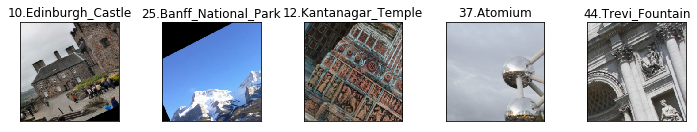

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def imshow (image, title=None):
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0,1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

dataiter = iter(train_loader)
images, labels = dataiter.next()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])



### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU

use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum =0.9)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        #conv layer (depth from 3 -->16), 3x3 kernels
        self.conv1 = nn.Conv2d(3,16,3, padding = 1)
        #conv layer (depth from 16 -->32), 3x3 kernels
        self.conv2 = nn.Conv2d(16,32,3, padding = 1)
        #conv layer (depth from 32 -->64), 3x3 kernels
        self.conv3 = nn.Conv2d(32,64,3, padding = 1)
        
        #conv layer (depth from 64 -->128), 3x3 kernels
        ##self.conv4 = nn.Conv2d(64,128,3, padding = 1)
        #conv layer (depth from 128 -->256), 3x3 kernels
        ##self.conv5 = nn.Conv2d(128,256,3, padding = 1)
        
        
        #pooling layer to reduce dimensions by 2
        self.pool = nn.MaxPool2d(2,2)
        #dropout layer
        self.dropout = nn.Dropout(0.25)
        #fully connected layer
        self.fc1 = nn.Linear(64 *28 * 28, 500)
        #fully connected layer2
        self.fc2 = nn.Linear(500, 50)
            
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
##        x = self.pool(F.relu(self.conv4(x)))
##        x = self.pool(F.relu(self.conv5(x)))
        
        x= x.view(-1, 64 *28 * 28)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

Used an architecture that consists in 3 convolutional layers they augment the layers from 3 to 64 layers in order to capture a bigger amount of features of each training image. Each layer has a pooling layer to compress the size of the images. 
Then I added 2 fully connected layers and a dropout of 25%. These layers go from a big size of features 50,176 down to 50. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            #Forward pass
            output = model(data)
            #Calculate loss
            loss = criterion(output, target)
            
            #backpropagation step
            loss.backward()
            
            #update parameters
            optimizer.step()
            
            #Average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1)) * (loss.data.item() - train_loss))
                   

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss
            
            #Forward pass
            output = model(data)
            #Calculate loss
            loss = criterion(output, target)
            
            
            #Calulate average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data.item() - valid_loss))
        

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for linear layer in a model
    if classname.find('Linear') != -1:
        #get number of inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0,y)
        m.bias.data.fill_(0)


#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.873447 	Validation Loss: 3.740618
validation loss decreased (inf --> 3.740618). Saving model ...
Epoch: 2 	Training Loss: 3.756052 	Validation Loss: 3.686512
validation loss decreased (3.740618 --> 3.686512). Saving model ...
Epoch: 3 	Training Loss: 3.717769 	Validation Loss: 3.618291
validation loss decreased (3.686512 --> 3.618291). Saving model ...
Epoch: 4 	Training Loss: 3.649555 	Validation Loss: 3.635739
Epoch: 5 	Training Loss: 3.602902 	Validation Loss: 3.601921
validation loss decreased (3.618291 --> 3.601921). Saving model ...
Epoch: 6 	Training Loss: 3.555253 	Validation Loss: 3.475183
validation loss decreased (3.601921 --> 3.475183). Saving model ...
Epoch: 7 	Training Loss: 3.519770 	Validation Loss: 3.450038
validation loss decreased (3.475183 --> 3.450038). Saving model ...
Epoch: 8 	Training Loss: 3.443250 	Validation Loss: 3.559490
Epoch: 9 	Training Loss: 3.403907 	Validation Loss: 3.391185
validation loss decreased (3.450038 --> 3.391185

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 30

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.876543 	Validation Loss: 3.800015
validation loss decreased (inf --> 3.800015). Saving model ...
Epoch: 2 	Training Loss: 3.756066 	Validation Loss: 3.717117
validation loss decreased (3.800015 --> 3.717117). Saving model ...
Epoch: 3 	Training Loss: 3.709728 	Validation Loss: 3.623953
validation loss decreased (3.717117 --> 3.623953). Saving model ...
Epoch: 4 	Training Loss: 3.661833 	Validation Loss: 3.543818
validation loss decreased (3.623953 --> 3.543818). Saving model ...
Epoch: 5 	Training Loss: 3.626374 	Validation Loss: 3.578424
Epoch: 6 	Training Loss: 3.557218 	Validation Loss: 3.481004
validation loss decreased (3.543818 --> 3.481004). Saving model ...
Epoch: 7 	Training Loss: 3.499114 	Validation Loss: 3.500247
Epoch: 8 	Training Loss: 3.474061 	Validation Loss: 3.478472
validation loss decreased (3.481004 --> 3.478472). Saving model ...
Epoch: 9 	Training Loss: 3.439965 	Validation Loss: 3.492506
Epoch: 10 	Training Loss: 3.411304 	Validation L

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.608771


Test Accuracy: 33% (423/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [4]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

#Set percentage of validation batch
valid_batch = 0.2

#Import the data sets
data_dir = '/data/landmark_images/'

train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'


#Do transforms for each data set
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])
                                         ])


testing_transforms = transforms.Compose([transforms.Resize(256), 
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(), 
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])
                                        ])


#load datasets with Imagefolder
image_datasets = [datasets.ImageFolder(train_dir, transform=training_transforms),
                  datasets.ImageFolder(test_dir, transform=testing_transforms)]

#Split train data to get a set for validation

num_train = len(image_datasets[0])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_batch*num_train))
train_idx , valid_idx = indices[split:], indices[:split]

#define samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(image_datasets[0], batch_size = 20, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(image_datasets[0], batch_size = 20, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(image_datasets[1], batch_size = 20)



loaders_transfer = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}
#Identify classes
classes = image_datasets[0].classes



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [5]:
## TODO: select loss function
import torch.nn as nn
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum =0.9)
    return optimizer


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [6]:
## TODO: Specify model architecture
use_cuda = torch.cuda.is_available()

model_transfer = models.vgg16(pretrained=True)

print(model_transfer)

n_inputs = model_transfer.classifier[6].in_features

## new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs,len(classes))

model_transfer.classifier[6] = last_layer

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 90798078.26it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I selected the VGG 16 pretrained model and extracted the features from the 6th layer and froze the features by turning the gradient off.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

#model_transfer.apply(custom_weight_init)
model_transfer = train(20, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.569807 	Validation Loss: 1.708567
validation loss decreased (inf --> 1.708567). Saving model ...
Epoch: 2 	Training Loss: 1.684285 	Validation Loss: 1.464860
validation loss decreased (1.708567 --> 1.464860). Saving model ...
Epoch: 3 	Training Loss: 1.442979 	Validation Loss: 1.315817
validation loss decreased (1.464860 --> 1.315817). Saving model ...
Epoch: 4 	Training Loss: 1.329848 	Validation Loss: 1.334702
Epoch: 5 	Training Loss: 1.239880 	Validation Loss: 1.303187
validation loss decreased (1.315817 --> 1.303187). Saving model ...
Epoch: 6 	Training Loss: 1.141365 	Validation Loss: 1.216891
validation loss decreased (1.303187 --> 1.216891). Saving model ...
Epoch: 7 	Training Loss: 1.093482 	Validation Loss: 1.225955
Epoch: 8 	Training Loss: 1.036287 	Validation Loss: 1.219490
Epoch: 9 	Training Loss: 1.004904 	Validation Loss: 1.247325
Epoch: 10 	Training Loss: 0.976912 	Validation Loss: 1.139186
validation loss decreased (1.216891 --> 1.139186). Sav

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
import torch.nn.functional as F
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [12]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.777825


Test Accuracy: 79% (996/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [44]:
import cv2
from PIL import Image
import torch
from torchvision import datasets, transforms, models

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def process_image(image):
    pil_image = Image.open(image).convert('RGB')
    
    #perform transformations
    adjust_image = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])
    #adjust image using transformations
    image = adjust_image(pil_image)
    
    return image

def predict_landmarks(img_path, topk=5):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    # transform the image by running it through the process_image method
    image = torch.unsqueeze(process_image(image_path),0).float()
    
    #Enable no grad to prevent a backward step and reduce memory consumption
    with torch.no_grad():
        #Send image and label to the gpu/device
        if use_cuda:
            image = image.cuda()
        ##print(image.shape)
        
        #push the image into the network
        output = model_transfer(image)
        
        
        probability = F.softmax(output, dim=1)
        probs = np.array(probability.topk(topk)[0][0])
        class_values, class_indices = torch.topk(probability, topk)
        class_indices = class_indices.cpu().numpy()
        class_values = class_values.detach().cpu().numpy()
        class_names = [classes[val] for val in class_indices[0]]
        ##print(class_names)
        
 #Old original code       
    #Calculate the probability using the softmax function
    ##probability = F.softmax(output, dim=1)
    #Create the array of top probabilities
    ##probs = np.array(probability.topk(topk)[0][0])
    
    #Determine classes
    ##class_values, class_indices = torch.topk(probability, topk)
    ##class_indices = class_indices.cpu().numpy()
    ##class_names = [classes[val] for val in class_indices[0]]

    return probs, class_names


In [53]:
# test on a sample image
image_path = 'images/OwnImages/Arco.jpg'
#image_path = 'images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg'
predict_landmarks(image_path, 5)

(array([  9.96314824e-01,   3.66655528e-03,   7.90843296e-06,
          3.41555369e-06,   3.38318046e-06], dtype=float32),
 ['39.Gateway_of_India',
  '49.Temple_of_Olympian_Zeus',
  '26.Pont_du_Gard',
  '35.Monumento_a_la_Revolucion',
  '06.Niagara_Falls'])

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

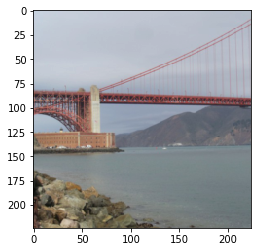

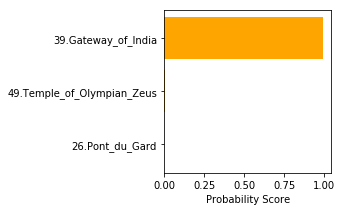

In [54]:
def suggest_locations(img_path):
    # get landmark predictions
    probs, class_names = predict_landmarks(img_path, 3)

    ## TODO: display image and display landmark predictions
    
    image = process_image(img_path)

    #Show the image using imshow 
    fig = imshow(image)
    #fig.axis('off') #remove axis markers  ##Doesn't work
    #fig.title(class_indices[0]) #Add the most likely title  ##Doesn't work

    #List all other possible titles
    other_names = [str(index) for index in class_names]
    y_pos = np.arange(len(other_names))
    scores = np.array(probs)
    
    #Create barh plot, inspired by https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.barh(y_pos, scores, align='center', color = 'orange')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(other_names)
    ax.invert_yaxis()  # reorganize from top to bottom scores
    ax.set_xlabel('Probability Score')

    plt.show()
       

# test on a sample image
img_path = 'images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg'

predict_landmarks(img_path)
suggest_locations(img_path)

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
My outputs are not what I expected, the model is not bad, it achieves 79% butit has proven that is not accurate enough.
The possible improvements are:
1- Trying a different optimizer might be helpful to achieve a better training/validation loss.

2 - Tweaking the learning rate might also be hlepful to achieve higher accuracy within the model.

3 - Experimenting by using another pretrained model might also give different results. 

In [56]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os

path1 = 'images/OwnImages/Arco.jpg'
path2 = 'images/OwnImages/sydney.jpg'
path3 = 'images/OwnImages/Brooklyn.jpg'
path4 = 'images/OwnImages/Oslo.jpg'

predict_landmarks(path1,3)
print(probs)
print(class_names)
predict_landmarks(path2,3)
predict_landmarks(path3,3)
predict_landmarks(path4,3)


suggest_locations(path1)
suggest_locations(path2)
suggest_locations(path3)
suggest_locations(path4)


NameError: name 'probs' is not defined